In [1]:
import math
import time
import threading
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
#将图的节点进行统一映射
def nodes_map(graph):
    node2id  = {}
    id2node = []
    num = 0
    for node in graph.nodes():
        node2id[node] = num
        id2node.append(node)
        num += 1
    return node2id, id2node

def creat_alias_table(prob_dist):
    N = len(prob_dist)
    norm_prob = np.array(prob_dist) * N
    prob, alias = [0] * N, [0] * N
    small, large = [], []
    for i, p in enumerate(norm_prob):
        if p >= 1.0:
            large.append(i)
        else:
            small.append(i)
    while small and large:
        small_index, large_index = small.pop(), large.pop()
        prob[small_index] = norm_prob[small_index]
        alias[small_index] = large_index
        norm_prob[large_index] = norm_prob[large_index] - (1.0 - norm_prob[small_index])
        if norm_prob[large_index] >= 1.0:
            large.append(large_index)
        else:
            small.append(large_index)
    while large:
        prob[large.pop()] = 1
    while small:
        prob[small.pop()] = 1
    return prob, alias

def alias_sample(prob, alias):
    N = len(prob)
    i = int(np.random.random()*N)
    p = np.random.random()
    if p <= prob[i]:
        return i
    else:
        return alias[i]

def cosine_similarity(a,b):
    dot = np.dot(a,b)
    normal = np.sqrt(sum(np.power(a,2))) * np.sqrt(sum(np.power(b,2)))
    sim = dot / normal
    return sim

In [12]:
def read_node_label(filename, skip_head=False):
    fin = open(filename, 'r')
    X = []
    Y = []
    while 1:
        if skip_head:
            fin.readline()
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        X.append(vec[0])
        Y.append(vec[1:])
    fin.close()
    return X, Y

class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)


class Classifier(object):

    def __init__(self, embeddings, clf):
        self.embeddings = embeddings
        self.clf = TopKRanker(clf)
        self.binarizer = MultiLabelBinarizer(sparse_output=True)

    def train(self, X, Y, Y_all):
        self.binarizer.fit(Y_all)
        X_train = [self.embeddings[x] for x in X]
        Y = self.binarizer.transform(Y)
        self.clf.fit(X_train, Y)

    def evaluate(self, X, Y):
        top_k_list = [len(l) for l in Y]
        Y_ = self.predict(X, top_k_list)
        Y = self.binarizer.transform(Y)
        averages = ["micro", "macro", "samples", "weighted"]
        results = {}
        for average in averages:
            results[average] = f1_score(Y, Y_, average=average)
        results['acc'] = accuracy_score(Y,Y_)
        print('-------------------')
        print(results)
        return results
        print('-------------------')

    def predict(self, X, top_k_list):
        X_ = np.asarray([self.embeddings[x] for x in X])
        Y = self.clf.predict(X_, top_k_list=top_k_list)
        return Y

    def split_train_evaluate(self, X, Y, train_precent, seed=0):
        state = np.random.get_state()

        training_size = int(train_precent * len(X))
        np.random.seed(seed)
        shuffle_indices = np.random.permutation(np.arange(len(X)))
        X_train = [X[shuffle_indices[i]] for i in range(training_size)]
        Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
        X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
        Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]

        self.train(X_train, Y_train, Y)
        np.random.set_state(state)
        return self.evaluate(X_test, Y_test)
    
def evaluate_embeddings(embeddings, filename):
    X, Y = read_node_label(filename)
    tr_frac = 0.8
    print("Training classifier using {:.2f}% nodes...".format(
        tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)

def plot_embeddings(embeddings,filename):
    X, Y = read_node_label(filename)

    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)
    plt.figure(figsize = (17,10))
    for c, idx in list(color_idx.items()):
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()

In [4]:
class LINE(object):
    def __init__(self, graph, embedding_size=10, negative_num=5,order=2, thread_nums = 5, init_rho = 0.025, m = 10):
        self.graph = graph
        self.node_nums = graph.number_of_nodes()
        self.edge_nums = graph.number_of_edges()
        self.node2id, self.id2node = nodes_map(self.graph)
        self.edges = []

        self.embedding_size = embedding_size
        self.negative_num = negative_num
        self.order = order
        self.init_rho = init_rho
        self.rho = 0.025

        self.thread_nums = thread_nums
        self.total_samples = graph.number_of_edges() * m
        self.current_sample_count = 0

        self.node_emb = {}
        self.context_emb = {}

        self.node_prob = []
        self.node_alias = []
        self.edge_prob = []
        self.edge_alias = []

    # 初始化节点表示向量 ?
    def init_embedding(self):
        for i in range(self.node_nums):
            self.node_emb[i] = (np.random.random(self.embedding_size) - 0.5) / self.embedding_size
            self.context_emb[i] = np.zeros(self.embedding_size) 

    #创建alias采样表
    def init_alias_table(self):
        power = 0.75
        #edge sample table
        self.edges = [(self.node2id[x[0]], self.node2id[x[1]]) for x in self.graph.edges()]
        total_sum = sum([self.graph[self.id2node[edge[0]]][self.id2node[edge[1]]].get('weight', 1.0) for edge in self.edges])
        edge_prob_dist = [self.graph[self.id2node[edge[0]]][self.id2node[edge[1]]].get('weight', 1.0) / total_sum for edge in self.edges]
        self.edge_prob, self.edge_alias = creat_alias_table(edge_prob_dist)
        #node sample table
        node_degree = np.zeros(self.node_nums)
        node2id = self.node2id
        for edge in self.graph.edges():
            node_degree[node2id[edge[0]]] += self.graph[edge[0]][edge[1]].get('weight', 1.0)
        total_sum = sum([math.pow(node_degree[i], power) for i in range(self.node_nums)])
        node_prob_dist = [math.pow(node_degree[i], power) / total_sum for i in range(self.node_nums)]
        self.node_prob, self.node_alias = creat_alias_table(node_prob_dist)

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def update_parameter(self, vec_u, vec_v, vec_error, label):
        x = np.dot(vec_u, vec_v)
        g = (label - self.sigmoid(x)) * self.rho
        vec_error += g * vec_v
        vec_v += g * vec_u
        return vec_v, vec_error

    def train_line_thread(self):
        count = 0
        last_count = 0
        while(True):
            if count > self.total_samples / self.thread_nums + 2:
                break
            
            if count - last_count > 10000:
                self.current_sample_count += (count - last_count)
                last_count = count
                self.rho = self.init_rho * (1 - self.current_sample_count / (self.total_samples + 1))
                if self.rho < self.init_rho * 0.0001:
                    self.rho = self.init_rho * 0.0001
            
            curedge = alias_sample(self.edge_prob, self.edge_alias) #随机取一条边
            u = self.edges[curedge][0]
            v = self.edges[curedge][1]
            
            vec_error = np.zeros(self.embedding_size)
            
            # Negative Sample
            for n in range(self.negative_num + 1):
                if n == 0:
                    target = v
                    label = 1
                else:
                    target = alias_sample(self.node_prob, self.node_alias)
                    if target == v:
                        target = alias_sample(self.node_prob, self.node_alias)
                    label = 0
                if self.order == 1:
                    self.node_emb[target], vec_error = self.update_parameter(self.node_emb[u], self.node_emb[target], vec_error, label)
                if self.order == 2:
                    self.context_emb[target], vec_error = self.update_parameter(self.node_emb[u], self.context_emb[target], vec_error, label)
                    
            self.node_emb[u] += vec_error
            count += 1

    def train(self):
        # 创建多线程
        threads = []
        print('Initial')
        #初始化
        self.init_embedding()
        self.init_alias_table()
        print('Initial Finished....')
        for i in range(self.thread_nums):
            thread = threading.Thread(target=self.train_line_thread())
            threads.append(thread)
        print('Start training.....')
        start = time.time()
        for i in range(self.thread_nums):
            threads[i].start()
        for i in range(self.thread_nums):
            threads[i].join()
        end = time.time()
        print('Train Finished')
        print('Total time: %d' % (end - start))
        
    def get_embedding(self, c = 'node', normalize = True):
        '''
        c: 'node' or 'context'
        normalize: 表示是否对向量归一化
        '''
        self.embedding = {}
        self.normal_embedding = {}
        id2node = self.id2node
        #返回节点向量还是context向量
        if c == 'node':
            embeddings = self.node_emb
        else:
            embeddings = self.context_emb
        for i, e in embeddings.items():
            self.embedding[id2node[i]] = e
        #是否对向量归一化    
        if normalize:
            for i, e in self.embedding.items():
                s = sum(np.power(e, 2))
                normal = np.sqrt(s)
                self.normal_embedding[i] = e / normal
            return self.normal_embedding
        return self.embedding

Initial
Initial Finished....
Start training.....
Train Finished
Total time: 0
Training classifier using 80.00% nodes...


D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


-------------------
{'micro': 0.64864864864864868, 'macro': 0.49058087263550038, 'samples': 0.64864864864864868, 'weighted': 0.64163440217780598, 'acc': 0.64864864864864868}


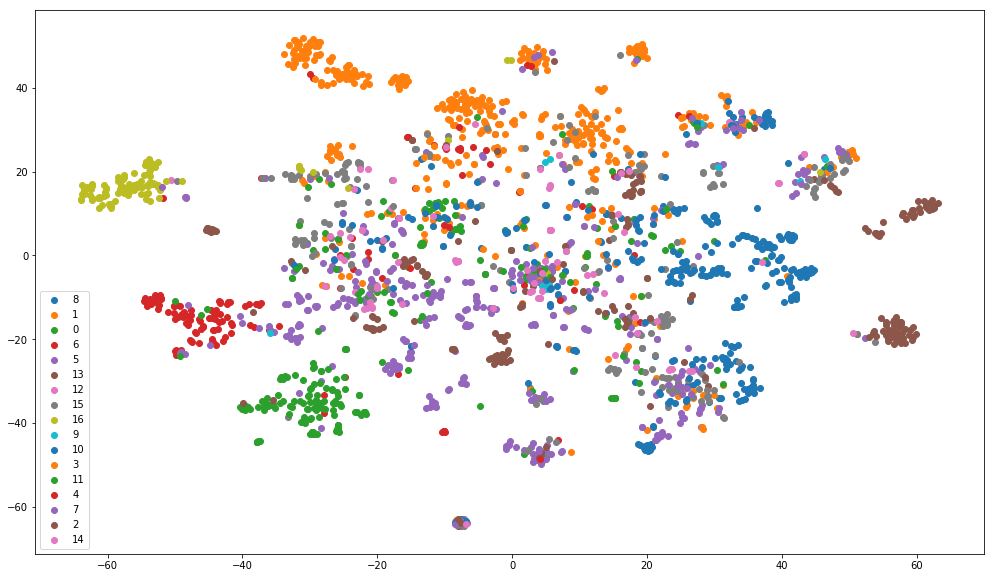

In [15]:
if __name__ == '__main__':
    file = r'D:\Recommender-System\Graph Embedding\Wiki_edgelist.txt'
    filename = r'D:\Recommender-System\Graph Embedding\wiki_labels.txt'
    G = nx.read_edgelist(file, create_using=nx.DiGraph(), nodetype=None,data=[('weight', int)])
    model = LINE(graph = G,embedding_size=100, negative_num=5,order=2, thread_nums = 5, init_rho = 0.025, m = 200)
    model.train()
    embeddings = model.get_embedding(normalize = False) 
    evaluate_embeddings(embeddings, filename)
    plot_embeddings(embeddings, filename)

In [6]:
if __name__ == '__main__':
    file = r'D:\Recommender-System\Graph Embedding\Wiki_edgelist.txt'
    filename = r'D:\Recommender-System\Graph Embedding\wiki_labels.txt'
    G = nx.read_edgelist(file, create_using=nx.DiGraph(), nodetype=None,data=[('weight', int)])
    results_embeddings = []
    results = []
    for num in [50, 100, 500, 1000]:
        model = LINE(graph = G,embedding_size=100, negative_num=5,order=2, thread_nums = 5, init_rho = 0.025, m = num)
        model.train()
        embeddings = model.get_embedding(normalize = False) 
        res = evaluate_embeddings(embeddings, filename)
        results_embeddings.append(embeddings)
        results.append(res)

Initial
Initial Finished....
Start training.....
Train Finished
Total time: 0
Training classifier using 80.00% nodes...


D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


-------------------
{'micro': 0.37214137214137216, 'macro': 0.26040536357888028, 'samples': 0.37214137214137216, 'weighted': 0.35266525250546943, 'acc': 0.37214137214137216}
-------------------
Initial
Initial Finished....
Start training.....
Train Finished
Total time: 0
Training classifier using 80.00% nodes...


D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


-------------------
{'micro': 0.60291060291060294, 'macro': 0.4477866636454233, 'samples': 0.60291060291060294, 'weighted': 0.58960201415193925, 'acc': 0.60291060291060294}
-------------------
Initial
Initial Finished....
Start training.....
Train Finished
Total time: 0
Training classifier using 80.00% nodes...


D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


-------------------
{'micro': 0.6070686070686071, 'macro': 0.46889831844904789, 'samples': 0.6070686070686071, 'weighted': 0.60154491452194325, 'acc': 0.6070686070686071}
-------------------
Initial
Initial Finished....
Start training.....
Train Finished
Total time: 0
Training classifier using 80.00% nodes...
-------------------
{'micro': 0.61538461538461542, 'macro': 0.50539668832567231, 'samples': 0.61538461538461542, 'weighted': 0.61482738447956153, 'acc': 0.61538461538461542}
-------------------


D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Training classifier using 80.00% nodes...


D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


-------------------
{'micro': 0.60291060291060294, 'macro': 0.4477866636454233, 'samples': 0.60291060291060294, 'weighted': 0.58960201415193925, 'acc': 0.60291060291060294}
-------------------


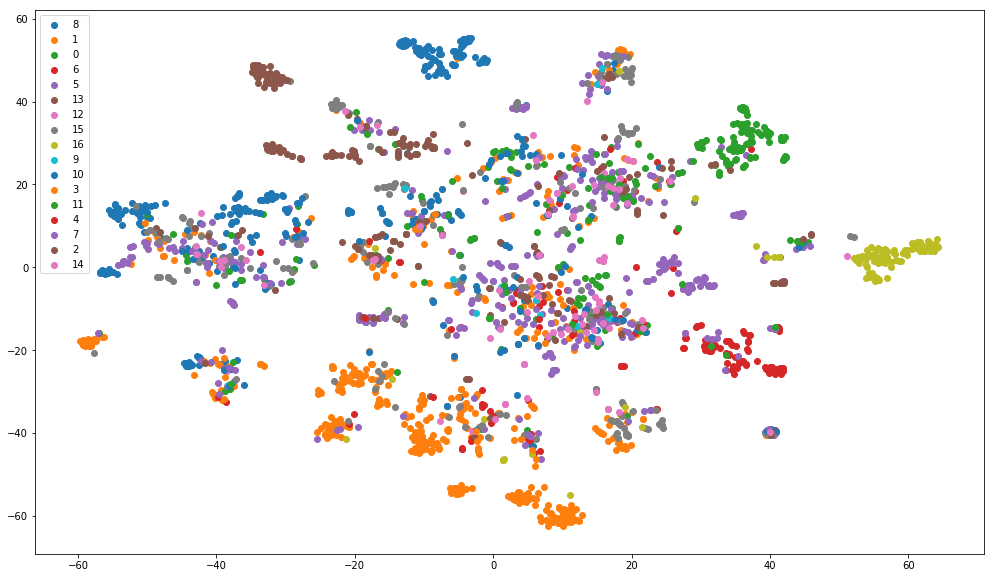

In [9]:
filename = r'D:\Recommender-System\Graph Embedding\wiki_labels.txt'
embeddings = results_embeddings[1]
evaluate_embeddings(embeddings, filename)
plot_embeddings(embeddings, filename)

Training classifier using 80.00% nodes...


D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


-------------------
{'micro': 0.61538461538461542, 'macro': 0.50539668832567231, 'samples': 0.61538461538461542, 'weighted': 0.61482738447956153, 'acc': 0.61538461538461542}
-------------------


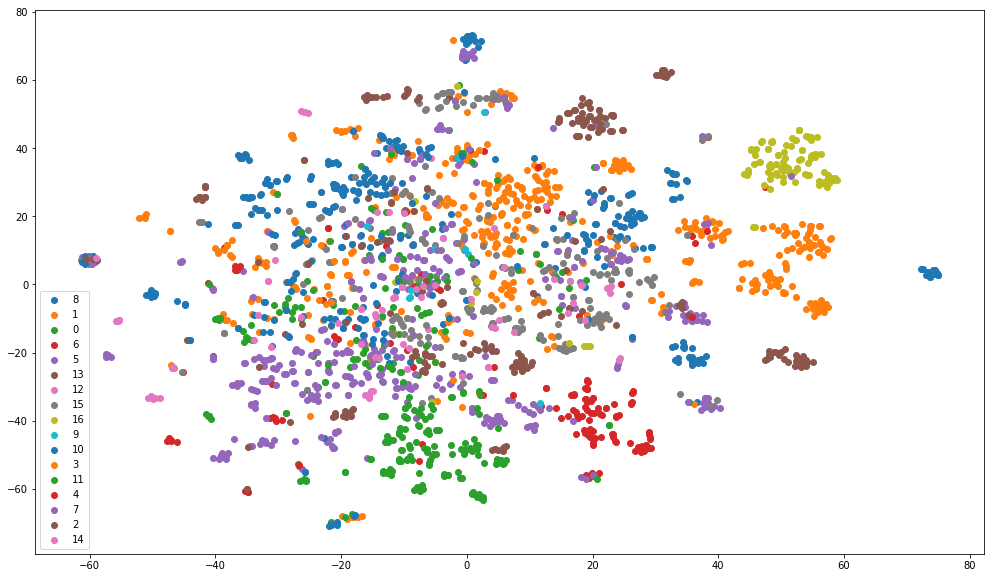

In [8]:
filename = r'D:\Recommender-System\Graph Embedding\wiki_labels.txt'
embeddings = results_embeddings[3]
evaluate_embeddings(embeddings, filename)
plot_embeddings(embeddings, filename)

Training classifier using 80.00% nodes...


D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Python\Install\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


-------------------
{'micro': 0.61746361746361744, 'macro': 0.46083371192862221, 'samples': 0.61746361746361744, 'weighted': 0.6045403422598381, 'acc': 0.61746361746361744}
-------------------
{'micro': 0.61746361746361744, 'macro': 0.46083371192862221, 'samples': 0.61746361746361744, 'weighted': 0.6045403422598381, 'acc': 0.61746361746361744}
-------------------


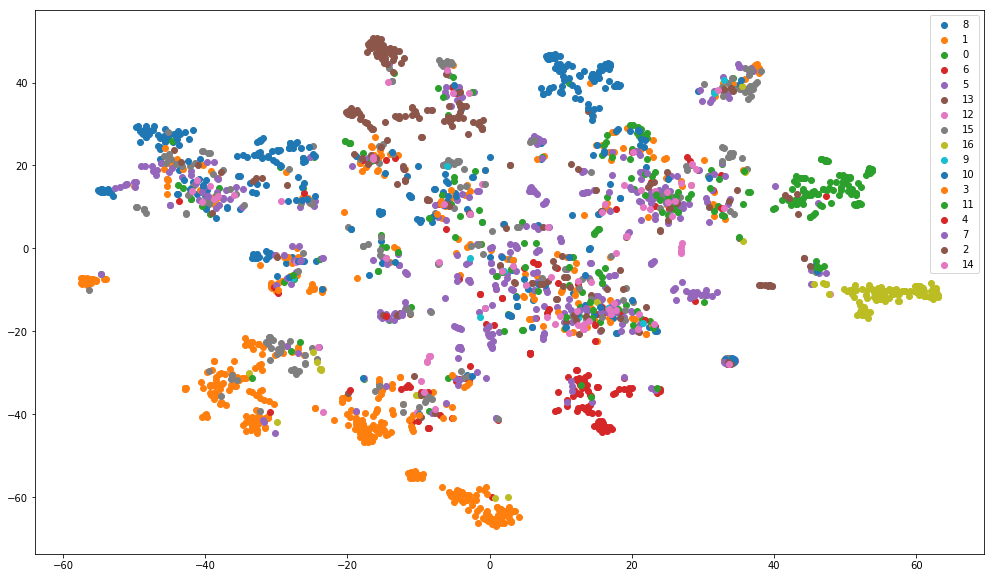

In [72]:
filename = r'D:\Recommender-System\Graph Embedding\wiki_labels.txt'
embeddings = model.get_embedding(normalize = False) 
evaluate_embeddings(embeddings, filename)
plot_embeddings(embeddings, filename)  #m = 100

In [11]:
a = model.node_emb[model.node2id['0']]
print('同类')
for i in range(1,11):
    b = model.node_emb[model.node2id[str(i)]]
    print(cosine_similarity(a,b))
print('不同类')
for i in range(11,21):
    c = model.node_emb[model.node2id[str(i)]]
    print(cosine_similarity(a,c))

同类
0.435278942875
0.571229805247
0.343540586387
0.437778658081
0.435609671546
0.470541398896
0.612893940678
0.545938017023
0.612737190967
0.337447558757
不同类
0.372707252228
0.312973610056
0.297549738233
0.37696457531
0.410648943113
0.305528666392
0.296694532219
0.398155248325
0.384162243658
0.377213853052
